### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib.colors import ListedColormap


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

/srv/conda/envs/data100/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Loading Data

In [2]:
image1 = pd.read_fwf("image1.txt",header=None, names=['y','x','label','NDAI','SD','CORR','DF','CF','BF','AF','AN'])
image2 = pd.read_fwf("image2.txt",header=None, names=['y','x','label','NDAI','SD','CORR','DF','CF','BF','AF','AN'])
image3 = pd.read_fwf("image3.txt",header=None, names=['y','x','label','NDAI','SD','CORR','DF','CF','BF','AF','AN'])

In [3]:
complete = image1.append(image2).append(image3)
complete = complete.loc[complete.loc[:,"label"]!=0,:] #exclude pixels without expert labels

In [4]:
complete.describe()

,y,x,label,NDAI,SD,CORR,DF,CF,BF,AF,AN
count,208061.000000,208061.000000,208061.000000,208061.000000,208061.000000,208061.000000,208061.000000,208061.000000,208061.000000,208061.000000,208061.000000
mean,192.654731,225.287151,0.515085,0.803550,5.650996,0.187919,271.665515,247.369454,224.969889,202.078752,188.531220
std,109.579032,89.580863,0.857141,1.317232,7.677959,0.108766,43.050678,42.071867,43.475216,42.930127,40.346016
min,2.000000,65.000000,-1.000000,-1.681146,0.198708,-0.361673,45.282322,31.191650,24.489492,22.348558,25.021715
25%,96.000000,147.000000,1.000000,-0.519009,1.189895,0.123267,245.364530,219.215760,200.363970,185.627880,176.081590
50%,196.000000,221.000000,1.000000,0.953510,2.804174,0.153763,282.287810,259.826080,237.817080,213.156600,199.145400
75%,286.000000,309.000000,1.000000,1.883428,6.945827,0.225659,298.663910,279.790470,259.763460,236.475680,217.325270
max,383.000000,369.000000,1.000000,4.346025,110.467640,0.814400,391.251500,352.998840,311.969480,310.753330,297.158750


### Splitting Data

In [5]:
block1 = complete.loc[complete.loc[:,'y']<96,:]
block2 = complete.loc[(complete.loc[:,'y']>=96) & (complete.loc[:,'y']<196),:]
block3 = complete.loc[(complete.loc[:,'y']>=196) & (complete.loc[:,'y']<286),:]
block4 = complete.loc[complete.loc[:,'y']>286,:]

In [6]:
train1, test1 = train_test_split(block1,train_size=int(np.ceil(block1.shape[0]*7/10)),shuffle=True,random_state=42)
train2, test2 = train_test_split(block2,train_size=int(np.ceil(block2.shape[0]*7/10)),shuffle=True,random_state=42)
train3, test3 = train_test_split(block3,train_size=int(np.ceil(block3.shape[0]*7/10)),shuffle=True,random_state=42)
train4, test4 = train_test_split(block4,train_size=int(np.ceil(block4.shape[0]*7/10)),shuffle=True,random_state=42)

/srv/conda/envs/data100/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
train1, val1 = train_test_split(train1,train_size=int(np.ceil(train1.shape[0]*5/7)),shuffle=True,random_state=42)
train2, val2 = train_test_split(train2,train_size=int(np.ceil(train2.shape[0]*5/7)),shuffle=True,random_state=42)
train3, val3 = train_test_split(train3,train_size=int(np.ceil(train3.shape[0]*5/7)),shuffle=True,random_state=42)
train4, val4 = train_test_split(train4,train_size=int(np.ceil(train4.shape[0]*5/7)),shuffle=True,random_state=42)

In [8]:
train = (
    train1.
    append(train2).
    append(train3).
    append(train4)
)

val = (
    val1.
    append(val2).
    append(val3).
    append(val4)
)

test = (
    test1.
    append(test2).
    append(test3).
    append(test4)
)

train_val = train.append(val)

In [17]:
train.loc[:,'label'].value_counts()

 1.0    78760
-1.0    24975
Name: label, dtype: int64

In [18]:
val.loc[:,'label'].value_counts()

 1.0    31430
-1.0    10061
Name: label, dtype: int64

In [16]:
train_val.loc[:,'label'].value_counts()

 1.0    110190
-1.0     35036
Name: label, dtype: int64

In [19]:
sum(train_val.loc[:,'label']==([-1]*train_val.shape[0])) / train_val.shape[0]

0.24125156652390067

### CVgeneric

In [21]:
def CVgeneric(features, labels, K, classifier, loss):
    errors = []
    folds = KFold(K)
    for train_idx, val_idx in folds.split(features):
        train_features, train_labels = features.iloc[train_idx,:], labels.iloc[train_idx]
        val_features, val_labels = features.iloc[val_idx,:], labels.iloc[val_idx]
        
        model = classifier.fit(train_features.loc[:,['NDAI','AF','AN']], train_labels)
        predictions = model.predict(val_features.loc[:,['NDAI','AF','AN']])
        
        errors.append(loss(predictions, val_labels))
    return errors        

### Loss Functions / Metrics

In [22]:
def accuracy(fitted, actual):
    return sum(fitted==actual)/len(actual)

In [23]:
def tpr(fitted, actual):
    true_positive = sum((fitted == actual) & (actual == -1))
    false_negative = sum((fitted != actual) & (actual == -1))
    return true_positive/(true_positive+false_negative)

In [24]:
def fpr(fitted, actual):
    false_positive = sum((fitted != actual) & (actual == 1))
    true_negative = sum((fitted == actual) & (actual == 1))
    return false_positive/(false_positive+true_negative)

### Features

In [25]:
features = ['NDAI','AF','AN']

### Logistic Regression

In [49]:
logistic_model=LogisticRegression().fit(train_val.loc[:,features],train_val.loc[:,'label'])

In [50]:
logistic_score = logistic_model.decision_function(train_val.loc[:,features])

In [51]:
logistic_fpr, logistic_tpr, logistic_thresholds = roc_curve(train_val.loc[:, 'label'], logistic_score)
logistic_roc_auc = auc(logistic_fpr, logistic_tpr)

In [ ]:
plt.plot(logistic_fpr,logistic_tpr,color='gold', label='AUC = %0.2f' % logistic_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(x=logistic_fpr[np.argmax(logistic_tpr-logistic_fpr)],
           y=logistic_tpr[np.argmax(logistic_tpr-logistic_fpr)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logistic)')
plt.legend(loc='lower right')
plt.savefig('ROC_Logistic (Y-Split)')
plt.show()

In [53]:
logistic_cutoff = logistic_thresholds[np.argmax(logistic_tpr-logistic_fpr)]
logistic_cutoff

1.182942324989595

In [54]:
pd.DataFrame({'Fold': np.arange(1,6), 'Accuracy': CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,LogisticRegression(),accuracy)}).set_index('Fold')

,Accuracy
Fold,
1,0.933691
2,0.911448
3,0.804338
4,0.724772
5,0.797280


In [71]:
final_logistic = LogisticRegression()
final_logistic.fit(train_val.loc[:,features],train_val.loc[:,'label'])
final_logistic_predictions = final_logistic.predict(test.loc[:,features])

accuracy(final_logistic_predictions, test.loc[:,'label'])

0.8356443915998522

### K-Nearest Neighbors

In [27]:
pd.DataFrame({
    'Fold': np.arange(1,6),
    'Accuracy': CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,KNeighborsClassifier(8),accuracy)
}).set_index('Fold')

,Accuracy
Fold,
1,0.946877
2,0.950146
3,0.906318
4,0.879910
5,0.908797


In [57]:
kNN_TPRs = []
for i in np.arange(1,11):
    tpr_dummy = CVgeneric(train_val.loc[:,['NDAI','AF','AN']],train_val.loc[:,'label'],5,KNeighborsClassifier(i),tpr)
    kNN_TPRs.append(tpr_dummy)

In [58]:
kNN_FPRs = []
for i in np.arange(1,11):
    fpr_dummy = CVgeneric(train.loc[:,['NDAI','AF','AN']],train.loc[:,'label'],5,KNeighborsClassifier(i),fpr)
    kNN_FPRs.append(fpr_dummy)

In [63]:
kNN_TPR_avg = pd.Series([np.mean(errors) for errors in kNN_TPRs])
kNN_FPR_avg = pd.Series([np.mean(errors) for errors in kNN_FPRs])

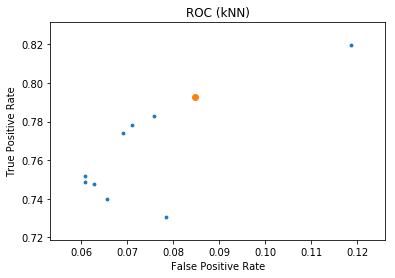

Optimal choice: k = 4


In [100]:
plt.scatter(x=kNN_FPR_avg, y=kNN_TPR_avg, s=8)
plt.scatter(x=kNN_FPR_avg[(kNN_TPR_avg-kNN_FPR_avg).idxmax()], y=kNN_TPR_avg[(kNN_TPR_avg-kNN_FPR_avg).idxmax()])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (kNN)')
plt.savefig('ROC_kNN (Y-Split)')
plt.show()
print("Optimal choice: k = " + str((kNN_TPR_avg-kNN_FPR_avg).idxmax()+1))

In [65]:
pd.DataFrame({'k': np.arange(1,11), 'TPR': kNN_TPR_avg, 'FPR': kNN_FPR_avg}).set_index('k')

,TPR,FPR
k,,
1,0.730372,0.078439
2,0.819838,0.118517
3,0.739936,0.065568
4,0.792866,0.084725
5,0.747750,0.062810
6,0.782689,0.075884
7,0.748944,0.060927
8,0.778025,0.071135
9,0.751731,0.060877


In [66]:
final_kNN = KNeighborsClassifier(4)
final_kNN.fit(train_val.loc[:,features],train_val.loc[:,'label'])
final_kNN_predictions = final_kNN.predict(test.loc[:,features])

accuracy(final_kNN_predictions, test.loc[:,'label'])

0.9159985217796488

#### Predicted Labels

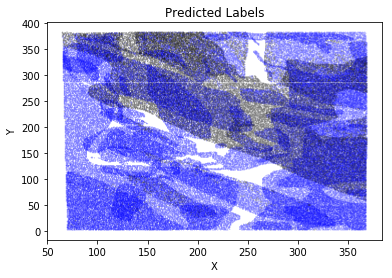

           Blue: Clouds        Black: Surface


In [99]:
plt.scatter(train_val.loc[:,'x'],train_val.loc[:,'y'],
            s=0.01, c=final_kNN.predict(train_val.loc[:,['NDAI','AF','AN']]),
            cmap=ListedColormap(['black','blue']))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predicted Labels')
plt.savefig('Predicted (Y-Split)')
plt.show()
print("           Blue: Clouds        Black: Surface")

#### Actual Labels

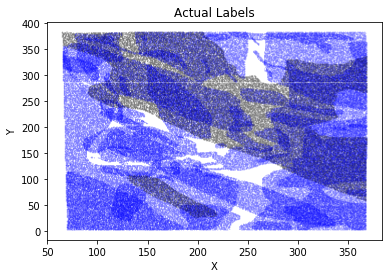

           Blue: Clouds        Black: Surface


In [98]:
plt.scatter(train_val.loc[:,'x'],train_val.loc[:,'y'],
            s=0.01, c=train_val.loc[:,'label'],cmap=ListedColormap(['black','blue']))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual Labels')
plt.savefig("Actual (Y-Split)")
plt.show()
print("           Blue: Clouds        Black: Surface")

#### Mislabeled

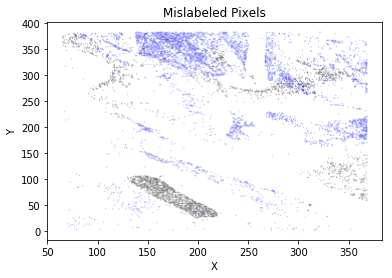

           Blue: Clouds        Black: Surface


In [95]:
plt.scatter(x=train_val.loc[train_val.loc[:,'label']!=final_kNN.predict(train_val.loc[:,features]),'x'],
            y=train_val.loc[train_val.loc[:,'label']!=final_kNN.predict(train_val.loc[:,features]),'y'],
            c=train_val.loc[train.append(val).loc[:,'label']!=final_kNN.predict(train_val.loc[:,features]),'label'],
            s=0.01,
            cmap=ListedColormap(['black', 'blue']))
plt.title('Mislabeled Pixels')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('Mislabeleld (Y-Split)')
plt.show()
print("           Blue: Clouds        Black: Surface")

### LDA / QDA

In [72]:
pd.DataFrame({
    'Fold': np.arange(1,6), 
    'Accuracy': CVgeneric(train.append(val).loc[:,features],train.append(val).loc[:,'label'],5,QuadraticDiscriminantAnalysis(),accuracy)}).set_index('Fold')

,Accuracy
Fold,
1,0.919645
2,0.853124
3,0.751489
4,0.677122
5,0.735411


In [73]:
pd.DataFrame({
    'Fold': np.arange(1,6), 
    'Accuracy': CVgeneric(train.append(val).loc[:,features],train.append(val).loc[:,'label'],5,LinearDiscriminantAnalysis(),accuracy)}).set_index('Fold')

,Accuracy
Fold,
1,0.929147
2,0.888587
3,0.763780
4,0.692649
5,0.756998


In [74]:
LDA = LinearDiscriminantAnalysis().fit(train_val.loc[:,features], train_val.loc[:,'label'])
LDA_decision = LDA.decision_function(train_val.loc[:,features])

QDA = QuadraticDiscriminantAnalysis().fit(train_val.loc[:,features], train_val.loc[:,'label'])
QDA_decision = QDA.decision_function(train_val.loc[:,features])

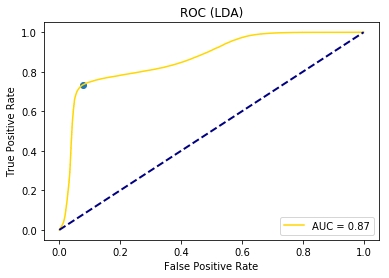

               Optimal Cutoff: C = 1.249


In [93]:
LDA_fpr, LDA_tpr, LDA_thresholds = roc_curve(train_val.loc[:,'label'], LDA_decision)
LDA_roc_auc = auc(LDA_fpr, LDA_tpr)

plt.plot(LDA_fpr, LDA_tpr, color='gold', label='AUC = %0.2f' % LDA_roc_auc)
plt.scatter(x=LDA_fpr[np.argmax(LDA_tpr-LDA_fpr)],
           y=LDA_tpr[np.argmax(LDA_tpr-LDA_fpr)])
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (LDA)')
plt.legend(loc='lower right')
plt.savefig("ROC_LDA (Y-split)")
plt.show()
print("               Optimal Cutoff: C = " + str(round(LDA_thresholds[np.argmax(LDA_tpr-LDA_fpr)],3)))

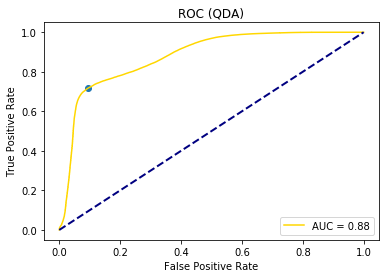

               Optimal Cutoff: C = 0.828


In [91]:
QDA_fpr, QDA_tpr, QDA_thresholds = roc_curve(train_val.loc[:,'label'], QDA_decision)
QDA_roc_auc = auc(QDA_fpr, QDA_tpr)

plt.plot(QDA_fpr, QDA_tpr, color='gold', label='AUC = %0.2f' % QDA_roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.scatter(x=QDA_fpr[np.argmax(QDA_tpr-QDA_fpr)],
           y=QDA_tpr[np.argmax(QDA_tpr-QDA_fpr)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (QDA)')
plt.legend(loc='lower right')
plt.savefig("ROC_QDA (Y-split)")
plt.show()
print("               Optimal Cutoff: C = " + str(round(QDA_thresholds[np.argmax(QDA_tpr-QDA_fpr)],3)))

### Random Forest

In [85]:
pd.DataFrame({
    'Fold': np.arange(1,6),
    'Accuracy': CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=40),accuracy)
}
).set_index('Fold')

,Accuracy
Fold,
1,0.945913
2,0.947048
3,0.902221
4,0.875676
5,0.905595


In [78]:
depths = np.arange(10,101,10)

In [79]:
### THIS TAKES LONG, BUT IT WORKS
RF_TPR = []
RF_FPR = []
RF_acc = []
for i in depths:
    RF_TPR.append(np.mean(pd.Series(CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=i),tpr))))
    RF_FPR.append(np.mean(pd.Series(CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=i),fpr))))
    RF_acc.append(np.mean(pd.Series(CVgeneric(train_val.loc[:,features],train_val.loc[:,'label'],5,RandomForestClassifier(max_depth=i),accuracy))))

In [80]:
RF_TPR = pd.Series(RF_TPR)
RF_FPR = pd.Series(RF_FPR)

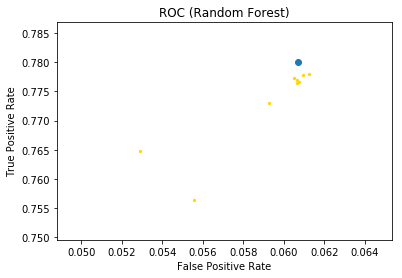

              Optimal Max Depth: depth = 40


In [89]:
plt.scatter(RF_FPR, RF_TPR, color='gold',s=5)
plt.scatter(RF_FPR[(RF_TPR-RF_FPR).idxmax()], RF_TPR[(RF_TPR-RF_FPR).idxmax()])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
#plt.legend(loc='lower right')
plt.savefig("ROC_RF (Y-split)")
plt.show()
print("              Optimal Max Depth: depth = " + str(depths[(RF_TPR-RF_FPR).idxmax()]))


In [26]:
final_RF = RandomForestClassifier(max_depth=40).fit(train_val.loc[:,features],train_val.loc[:,'label'])
final_RF_predictions = final_RF.predict(test.loc[:,features])

accuracy(final_RF_predictions, test.loc[:,'label'])

0.9200796953580668